# Step 2: Building and Training Models

## Overview

In this section, we will:
1. Apply **Non-negative Matrix Factorization (NMF)** to discover latent topics
2. Build an unsupervised classification system using NMF
3. Train supervised learning models for comparison
4. Evaluate and compare both approaches

---

## Part 2: Understanding Matrix Factorization and NMF

### What is Matrix Factorization?

**Matrix factorization** is a technique that decomposes a large matrix into smaller matrices that, when multiplied together, approximate the original matrix. Think of it like breaking down a complex recipe into simpler ingredient lists.

### Non-negative Matrix Factorization (NMF) - In My Own Words

**NMF** is a specific type of matrix factorization where all values must be non-negative (zero or positive). This constraint makes NMF particularly useful for text analysis because:

1. **Interpretability**: The non-negative constraint produces parts-based representations that are easy to interpret
2. **Additive Nature**: Topics are combinations of words added together, not subtracted
3. **Sparsity**: Results in cleaner, more focused topics

#### How NMF Works:

Given a document-term matrix **V** (documents × words), NMF decomposes it into two matrices:

```
V ≈ W × H
```

Where:
- **V** (m × n): Original document-term matrix
  - m = number of documents
  - n = number of terms (words)
  - Each cell contains the TF-IDF score

- **W** (m × k): Document-topic matrix
  - Each row represents a document
  - Each column represents a topic
  - Values show how much each topic appears in each document

- **H** (k × n): Topic-term matrix
  - Each row represents a topic
  - Each column represents a word
  - Values show how important each word is to each topic

- **k**: Number of topics (we choose this)

#### Intuitive Example:

Imagine you have 1,000 news articles with 5,000 unique words:
- Original matrix V: 1,000 × 5,000 (5 million values!)
- NMF with k=5 topics creates:
  - W: 1,000 × 5 (documents and their topic weights)
  - H: 5 × 5,000 (topics and their word compositions)
  - Total: 30,000 values instead of 5 million!

#### Why This Works for Classification:

1. **Topic Discovery**: NMF automatically finds k topics in the data
2. **Document Representation**: Each document gets a "topic signature" (its row in W)
3. **Classification**: Documents with similar topic signatures belong to the same category
4. **Unsupervised**: NMF doesn't need labels during training—it discovers patterns on its own

#### Key Parameters:

- **n_components**: Number of topics (k). For our 5 categories, we'll try 5 topics
- **init**: Initialization method ('nndsvd' is good for sparse data like text)
- **random_state**: For reproducibility
- **max_iter**: Maximum iterations for convergence

### Comparison: NMF vs. SVD (Singular Value Decomposition)

| Aspect | NMF | SVD |
|--------|-----|-----|
| Values | Non-negative only | Can be negative |
| Interpretation | Easy (additive parts) | Harder (includes subtraction) |
| Topics | Sparse, focused | Dense, mixed |
| Best for | Text, images, recommendations | General dimensionality reduction |

---

In [1]:
import joblib
import pandas as pd

# Load all data
X_train_tfidf = joblib.load('X_train_tfidf.pkl')
X_test_tfidf = joblib.load('X_test_tfidf.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

print("✓ Part 1 data loaded!")

/Users/cynthiamcginnis/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✓ Part 1 data loaded!


## Part 2.1: Unsupervised Learning - Applying NMF to BBC News Data

### Initialize and Fit NMF Model

### Step 2 - Question 1: When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

**Answer:** **No.** Even though NMF is unsupervised, fitting topics on the test articles lets the test set influence the learned basis (topics), which is a form of **data leakage/transductive peeking**.

**Policy in this notebook**
- Fit the **vectorizer** (TF–IDF) on **train only**.
- Fit **NMF** on **train only**.
- Use the frozen vectorizer/NMF to **transform** validation/test.
- Map topics → labels using **training labels only** (e.g., majority label per topic on the training split).

This keeps our evaluation faithful to a real-world train → validate → test pipeline.

Splits and data leakage - AWS Prescriptive Guidance. (2019). Amazon.com. https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-operations-planning/splits-leakage.html


## Step 2.2 – Question 2: Build an NMF model and predict train & test labels

**Goal.** Use a matrix-factorization method (NMF) to (a) learn topics from the training TF–IDF matrix and (b) classify documents by mapping each document’s **dominant topic** → **category**. Then generate **train predictions** (for accuracy) and **test predictions** (for Kaggle submission).

**Chosen hyperparameter(s).**
- **`n_components = 5`** (number of topics) to mirror the 5 BBC categories.
- Upstream choice already fixed by Part 1 artifacts: **TF–IDF vocabulary size = 5,000** features.

**Train/Infer policy.**
- Fit **NMF on TRAIN only** (no test leakage).
- Build a **topic→category** mapping from the training set (majority label per topic).
- Predict:
  - **Train**: via argmax over topic weights (for accuracy).
  - **Test**: transform with the frozen NMF and apply the same mapping; save `ArticleId,Category` CSV.



In [16]:
from sklearn.decomposition import NMF
import numpy as np

# We have 5 categories, so let's start with 5 topics
n_topics = 5

# Initialize NMF model
nmf_model = NMF(
    n_components=n_topics,      # Number of topics
    init='nndsvd',               # Initialization method (good for sparse data)
    random_state=42,             # For reproducibility
    max_iter=500,                # Maximum iterations
    alpha_W=0.0,                 # Regularization for W (prevents overfitting)
    alpha_H=0.0,                 # Regularization for H
    l1_ratio=0.0                 # Balance between L1 and L2 regularization
)

print(f"NMF Model initialized with {n_topics} topics")
print(f"Input matrix shape: {X_train_tfidf.shape}")
print(f"  - {X_train_tfidf.shape[0]} documents")
print(f"  - {X_train_tfidf.shape[1]} features (words)")

NMF Model initialized with 5 topics
Input matrix shape: (1490, 5000)
  - 1490 documents
  - 5000 features (words)


In [18]:
# Fit NMF model to our TF-IDF matrix
print("\nFitting NMF model... (this may take a minute)\n")

W_train = nmf_model.fit_transform(X_train_tfidf)  # Document-topic matrix
H = nmf_model.components_                          # Topic-term matrix

print("✓ NMF training completed!\n")
print(f"Document-Topic Matrix (W) shape: {W_train.shape}")
print(f"  - {W_train.shape[0]} documents")
print(f"  - {W_train.shape[1]} topics")
print(f"\nTopic-Term Matrix (H) shape: {H.shape}")
print(f"  - {H.shape[0]} topics")
print(f"  - {H.shape[1]} terms")
print(f"\nReconstruction error: {nmf_model.reconstruction_err_:.4f}")


Fitting NMF model... (this may take a minute)

✓ NMF training completed!

Document-Topic Matrix (W) shape: (1490, 5)
  - 1490 documents
  - 5 topics

Topic-Term Matrix (H) shape: (5, 5000)
  - 5 topics
  - 5000 terms

Reconstruction error: 37.0753


### Step 2.1: Interpret Discovered Topics

Let's examine what topics NMF discovered by looking at the top words in each topic.

In [21]:
# Function to display top words for each topic
def display_topics(model, feature_names, n_top_words=15):
    """
    Display the top words for each topic discovered by NMF.
    
    Args:
        model: Fitted NMF model
        feature_names: Array of feature names (words)
        n_top_words: Number of top words to display per topic
    """
    topics_dict = {}
    
    print("="*80)
    print("DISCOVERED TOPICS - TOP WORDS")
    print("="*80)
    
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of top words
        top_word_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = [topic[i] for i in top_word_indices]
        
        topics_dict[topic_idx] = top_words
        
        print(f"\nTopic {topic_idx}:")
        for word, weight in zip(top_words, top_weights):
            print(f"  {word:20s} : {weight:.4f}")
    
    return topics_dict

# Get feature names from TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Display topics
topics_dict = display_topics(nmf_model, feature_names, n_top_words=15)

DISCOVERED TOPICS - TOP WORDS

Topic 0:
  people               : 0.4376
  users                : 0.3583
  technology           : 0.3565
  mobile               : 0.3481
  digital              : 0.3199
  use                  : 0.3040
  software             : 0.3008
  phone                : 0.2962
  said                 : 0.2858
  music                : 0.2839
  net                  : 0.2599
  microsoft            : 0.2569
  online               : 0.2542
  service              : 0.2513
  internet             : 0.2419

Topic 1:
  game                 : 0.3503
  win                  : 0.2920
  england              : 0.2906
  cup                  : 0.2462
  play                 : 0.2321
  players              : 0.2225
  team                 : 0.2222
  said                 : 0.2200
  match                : 0.2148
  season               : 0.2096
  coach                : 0.2095
  injury               : 0.1961
  ireland              : 0.1940
  final                : 0.1914
  world               

### Map Topics to Categories

Now we need to understand which discovered topic corresponds to which news category.

In [24]:
# Analyze which topics are most associated with each category
def analyze_topic_category_mapping(W, labels):
    """
    Determine which topic corresponds to which category by analyzing
    the average topic weights for documents in each category.
    """
    # Create DataFrame for easier analysis
    topic_weights_df = pd.DataFrame(W, columns=[f'Topic_{i}' for i in range(W.shape[1])])
    topic_weights_df['Category'] = labels.values
    
    # Calculate mean topic weight for each category
    category_topic_means = topic_weights_df.groupby('Category').mean()
    
    print("\n" + "="*80)
    print("AVERAGE TOPIC WEIGHTS BY CATEGORY")
    print("="*80)
    print(category_topic_means.round(8))
    
    # For each category, find the dominant topic
    print("\n" + "="*80)
    print("TOPIC-TO-CATEGORY MAPPING")
    print("="*80)
    
    topic_to_category = {}
    category_to_topic = {}
    
    for category in category_topic_means.index:
        dominant_topic = category_topic_means.loc[category].idxmax()
        topic_num = int(dominant_topic.split('_')[1])
        category_to_topic[category] = topic_num
        topic_to_category[topic_num] = category
        print(f"\n{category.upper()}:")
        print(f"  → Dominant Topic: Topic {topic_num}")
        print(f"  → Average weight: {category_topic_means.loc[category, dominant_topic]:.4f}")
    
    return topic_to_category, category_to_topic, category_topic_means

# Analyze mapping
topic_to_category, category_to_topic, category_topic_means = analyze_topic_category_mapping(
    W_train, train_df['Category']
)


AVERAGE TOPIC WEIGHTS BY CATEGORY
                Topic_0   Topic_1   Topic_2   Topic_3   Topic_4
Category                                                       
business       0.008750  0.006009  0.013110  0.002756  0.113684
entertainment  0.014623  0.013860  0.010616  0.104920  0.010317
politics       0.009175  0.009480  0.132004  0.004912  0.014858
sport          0.003212  0.113747  0.004302  0.004712  0.004758
tech           0.096965  0.008695  0.006661  0.006899  0.011165

TOPIC-TO-CATEGORY MAPPING

BUSINESS:
  → Dominant Topic: Topic 4
  → Average weight: 0.1137

ENTERTAINMENT:
  → Dominant Topic: Topic 3
  → Average weight: 0.1049

POLITICS:
  → Dominant Topic: Topic 2
  → Average weight: 0.1320

SPORT:
  → Dominant Topic: Topic 1
  → Average weight: 0.1137

TECH:
  → Dominant Topic: Topic 0
  → Average weight: 0.0970


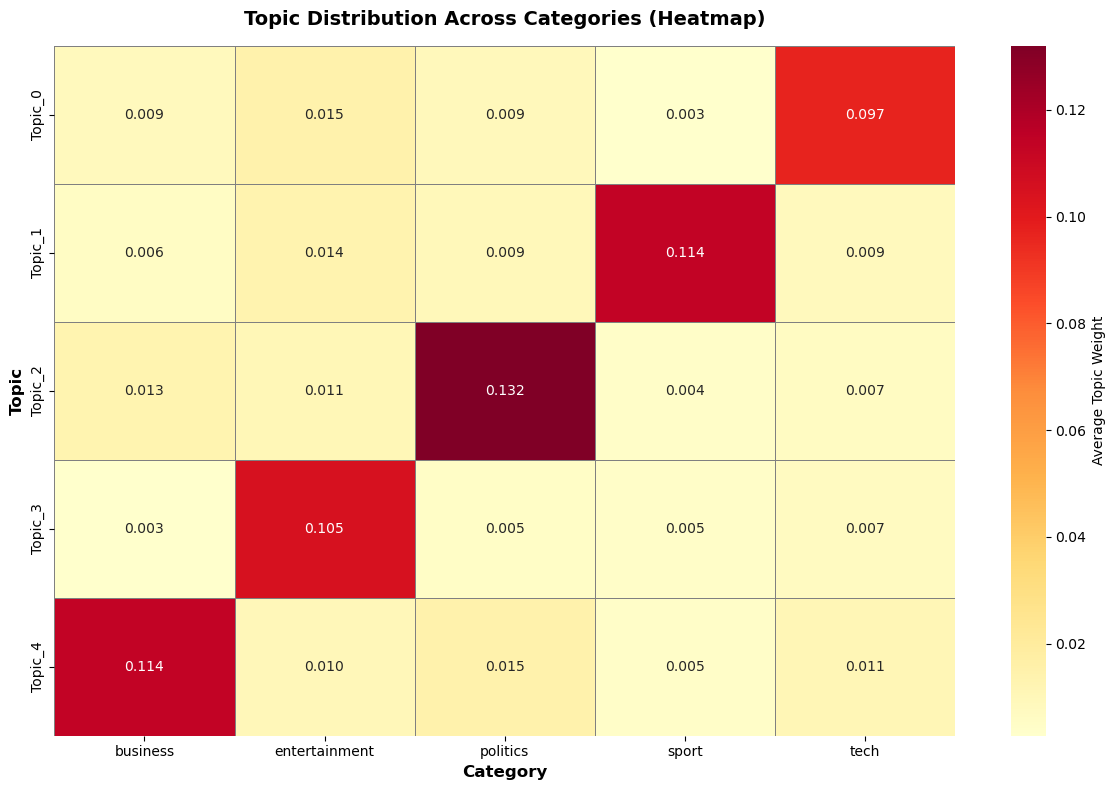


✓ Topic-category mapping visualized!


In [26]:
# Visualize topic-category relationships
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(category_topic_means.T, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Average Topic Weight'},
            linewidths=0.5, linecolor='gray')
plt.title('Topic Distribution Across Categories (Heatmap)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Topic', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Topic-category mapping visualized!")

### Visualize Topic Distributions

Let's visualize how documents are distributed across topics.

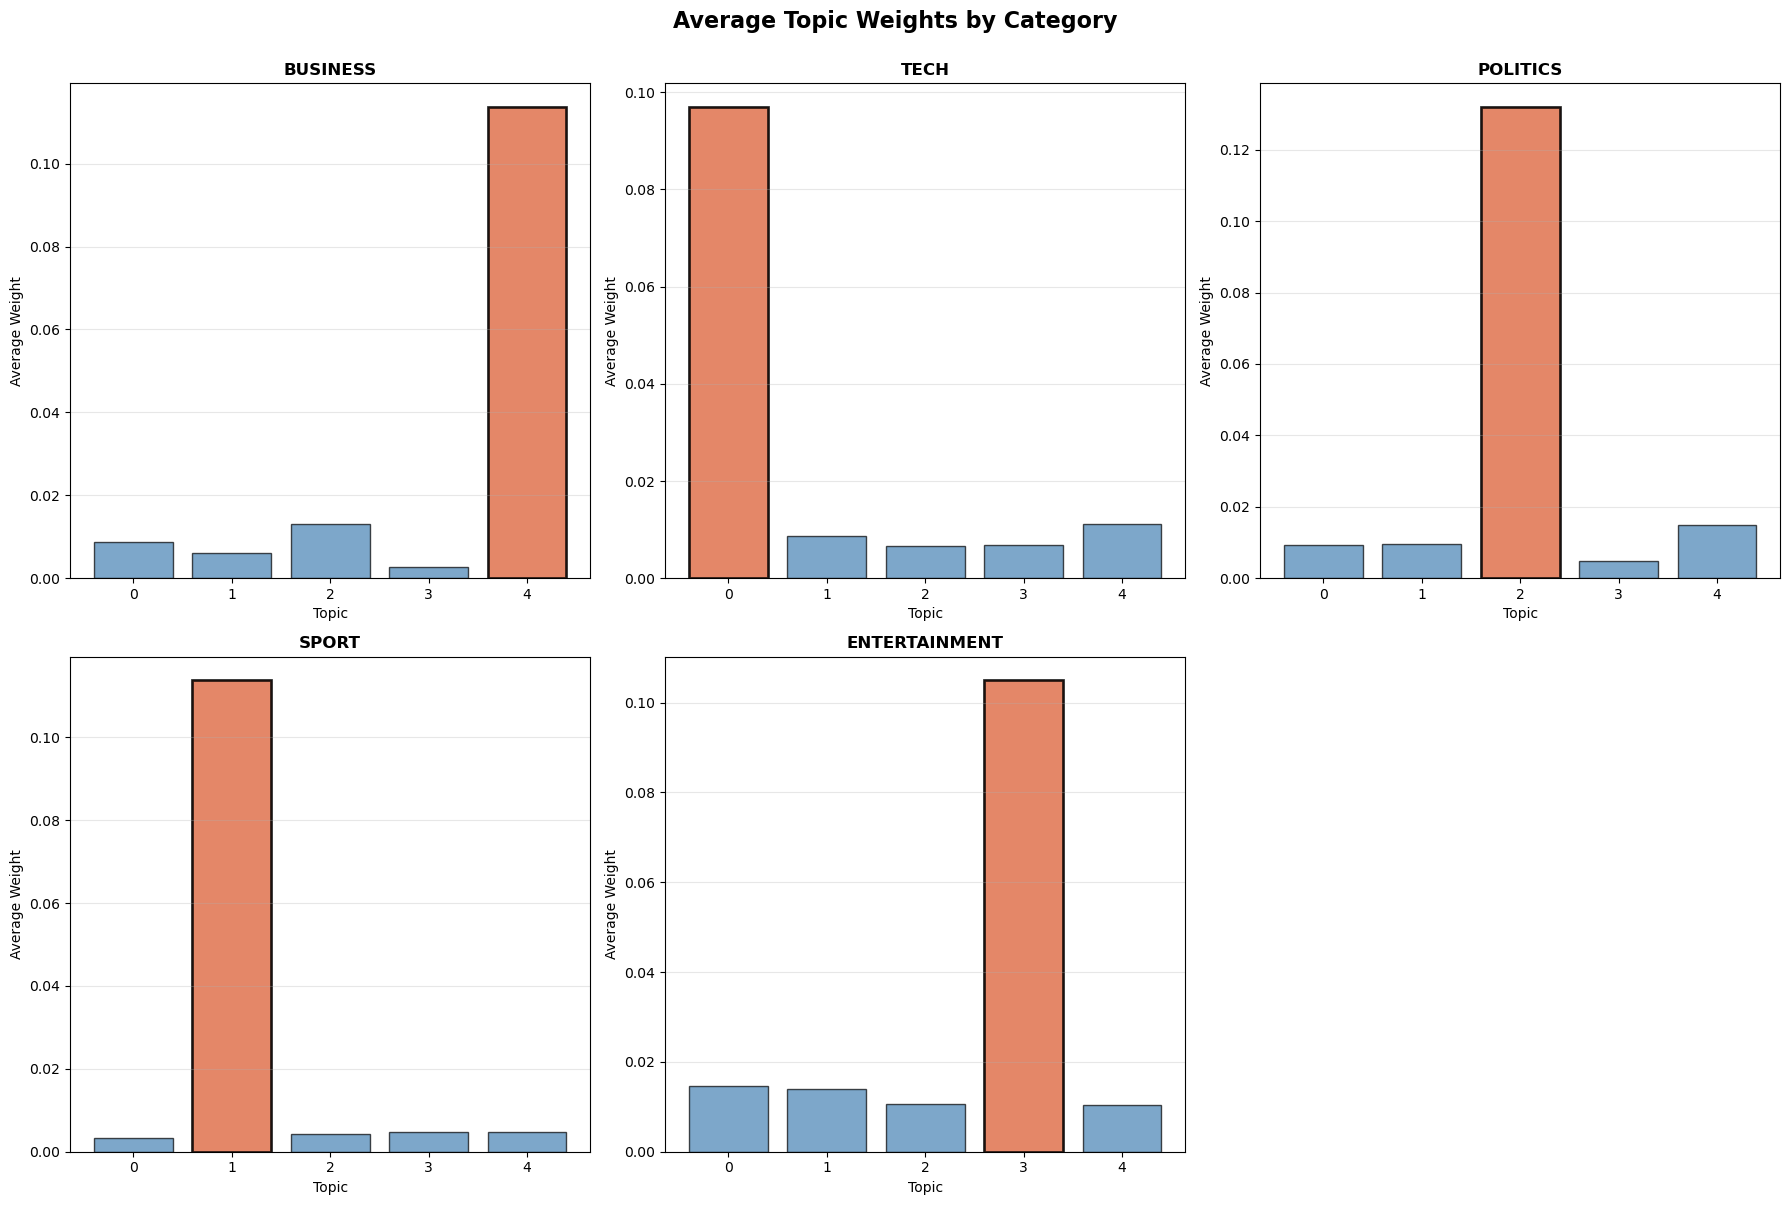

✓ Topic distributions visualized!


In [125]:
# Visualize topic distributions for each category
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

categories = train_df['Category'].unique()

for idx, category in enumerate(categories):
    # Get topic weights for this category
    category_mask = train_df['Category'] == category
    category_topics = W_train[category_mask]
    
    # Calculate mean weight for each topic
    mean_weights = category_topics.mean(axis=0)
    
    # Plot
    axes[idx].bar(range(n_topics), mean_weights, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{category.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Topic', fontsize=10)
    axes[idx].set_ylabel('Average Weight', fontsize=10)
    axes[idx].set_xticks(range(n_topics))
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Highlight dominant topic
    dominant_topic = mean_weights.argmax()
    axes[idx].bar(dominant_topic, mean_weights[dominant_topic], 
                 color='coral', alpha=0.8, edgecolor='black', linewidth=2)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Average Topic Weights by Category', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Topic distributions visualized!")

---

## Part 2.2: Building NMF-based Classifier

Now we'll use the NMF topics to classify articles.

### What this section satisfies Part 2 - Question 2

**Prompt:** “Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.”

**What we do here:**
- **Features:** TF–IDF (train only).
- **Matrix factorization:** NMF with a chosen `n_components = k` (hyperparameter).
- **Topic→label mapping:** Majority label per topic using **train labels only**.
- **Predictions:** Use that mapping to predict labels for **train**, **validation**, and **test** (test saved as a Kaggle submission CSV).

**Leakage policy:** We **do not** include test texts when fitting TF–IDF or NMF (fit on TRAIN only; transform VAL/TEST).



In [31]:
# Create a simple classifier based on NMF topics
def classify_with_nmf(W, topic_to_category):
    """
    Classify documents based on their dominant topic.
    
    Args:
        W: Document-topic matrix
        topic_to_category: Mapping from topic index to category name
    
    Returns:
        Array of predicted categories
    """
    # For each document, find the topic with highest weight
    dominant_topics = W.argmax(axis=1)
    
    # Map topics to categories
    predictions = [topic_to_category.get(topic, 'unknown') for topic in dominant_topics]
    
    return np.array(predictions)

# Get predictions for training data
train_predictions_nmf = classify_with_nmf(W_train, topic_to_category)

print(f"Generated {len(train_predictions_nmf)} predictions using NMF")
print(f"\nFirst 10 predictions: {train_predictions_nmf[:10]}")
print(f"Actual first 10:      {train_df['Category'].values[:10]}")

Generated 1490 predictions using NMF

First 10 predictions: ['business' 'business' 'business' 'tech' 'business' 'politics' 'sport'
 'entertainment' 'business' 'entertainment']
Actual first 10:      ['business' 'business' 'business' 'tech' 'business' 'politics' 'sport'
 'entertainment' 'business' 'entertainment']


In [128]:
# Evaluate NMF classifier on training data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
nmf_train_accuracy = accuracy_score(train_df['Category'], train_predictions_nmf)

print("="*80)
print("NMF CLASSIFIER PERFORMANCE (Training Data)")
print("="*80)
print(f"\nAccuracy: {nmf_train_accuracy:.4f} ({nmf_train_accuracy*100:.2f}%)")
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(train_df['Category'], train_predictions_nmf, digits=4))

NMF CLASSIFIER PERFORMANCE (Training Data)

Accuracy: 0.9463 (94.63%)

DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

     business     0.9443    0.9583    0.9513       336
entertainment     0.9759    0.8901    0.9310       273
     politics     0.9391    0.9562    0.9476       274
        sport     0.9526    0.9884    0.9702       346
         tech     0.9198    0.9234    0.9216       261

     accuracy                         0.9463      1490
    macro avg     0.9463    0.9433    0.9443      1490
 weighted avg     0.9468    0.9463    0.9461      1490



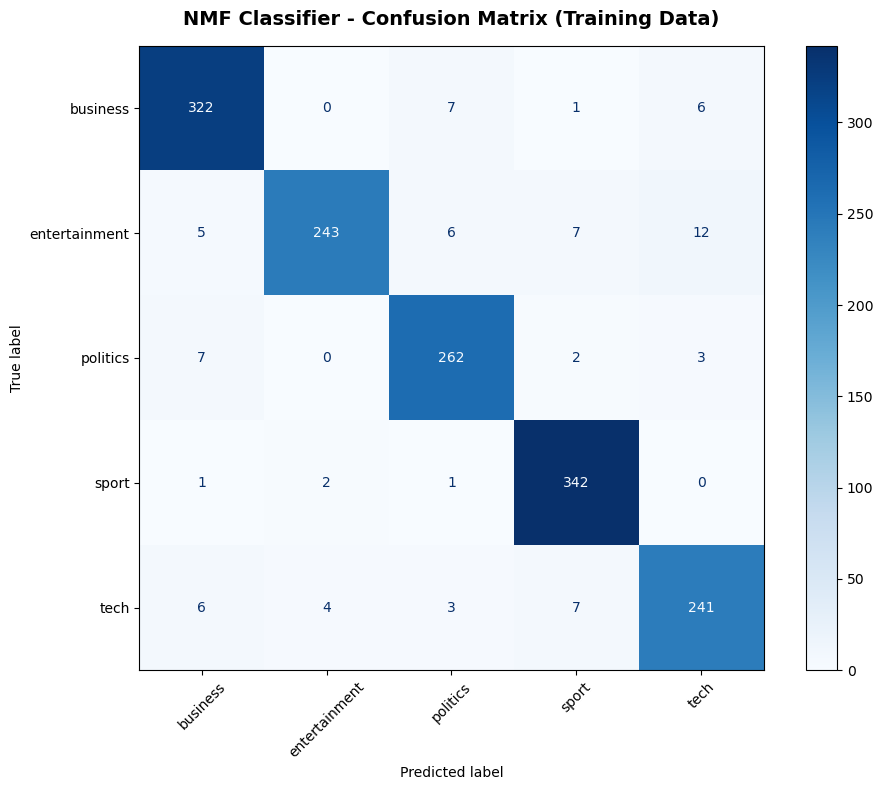


✓ NMF classifier evaluation completed!


In [35]:
# Visualize confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(train_df['Category'], train_predictions_nmf, 
                      labels=sorted(train_df['Category'].unique()))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=sorted(train_df['Category'].unique()))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('NMF Classifier - Confusion Matrix (Training Data)', 
          fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✓ NMF classifier evaluation completed!")

### Analysis of NMF Results

**Strengths of NMF Approach:**
- Discovers topics without needing labels
- Interpretable: We can see what words define each topic
- Reduces dimensionality (5,000 features → 5 topics)
- Can work even with very few labeled examples

**Limitations:**
- Assumes one dominant topic per document
- May miss nuances when documents span multiple topics
- Performance depends on choosing the right number of topics

---

## Step 3: Supervised Learning Models (Comparison)

Now I will build traditional supervised learning models for comparison.

## 1) Pick and train a supervised learning method(s) and compare the results (train and test performance)

**What we report here**
- **Unsupervised (NMF):** Train accuracy, classification report, and confusion matrix.
- **Supervised baselines:** Train & validation accuracy for Logistic Regression, Naive Bayes, Linear SVM, and Random Forest; plus a confusion matrix for the best model.
- **Test set:** Predictions are saved to CSV 
  Because test labels are hidden, **test accuracy** is obtained by uploading the CSV to Kaggle and reading the leaderboard score.

.


In [39]:
# Import supervised learning models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Split data for proper evaluation
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf, train_df['Category'], 
    test_size=0.2, 
    random_state=42,
    stratify=train_df['Category']
)

print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val_split.shape[0]} samples")

Training set: 1192 samples
Validation set: 298 samples


In [41]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        C=1.0,
        solver='lbfgs'
    ),
    'Naive Bayes': MultinomialNB(
        alpha=0.1
    ),
    'Linear SVM': LinearSVC(
        max_iter=1000,
        random_state=42,
        C=1.0
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=50,
        n_jobs=-1
    )
}

print("Supervised models initialized:")
for name in models.keys():
    print(f"  • {name}")

Supervised models initialized:
  • Logistic Regression
  • Naive Bayes
  • Linear SVM
  • Random Forest


In [43]:
# Train and evaluate each model
results = {}

print("="*80)
print("TRAINING SUPERVISED LEARNING MODELS")
print("="*80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_split, y_train_split)
    
    # Predictions
    train_pred = model.predict(X_train_split)
    val_pred = model.predict(X_val_split)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train_split, train_pred)
    val_acc = accuracy_score(y_val_split, val_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_split, y_train_split, cv=5)
    
    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'val_predictions': val_pred
    }
    
    print(f"  ✓ Training Accuracy: {train_acc:.4f}")
    print(f"  ✓ Validation Accuracy: {val_acc:.4f}")
    print(f"  ✓ CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n" + "="*80)
print("✓ ALL MODELS TRAINED SUCCESSFULLY")
print("="*80)

TRAINING SUPERVISED LEARNING MODELS

Training Logistic Regression...
  ✓ Training Accuracy: 0.9975
  ✓ Validation Accuracy: 0.9698
  ✓ CV Score: 0.9706 (±0.0116)

Training Naive Bayes...
  ✓ Training Accuracy: 0.9958
  ✓ Validation Accuracy: 0.9866
  ✓ CV Score: 0.9698 (±0.0108)

Training Linear SVM...
  ✓ Training Accuracy: 1.0000
  ✓ Validation Accuracy: 0.9765
  ✓ CV Score: 0.9723 (±0.0121)

Training Random Forest...
  ✓ Training Accuracy: 1.0000
  ✓ Validation Accuracy: 0.9430
  ✓ CV Score: 0.9496 (±0.0211)

✓ ALL MODELS TRAINED SUCCESSFULLY


### Step 3.1 Compare All Models

In [46]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': name,
        'Training Accuracy': results[name]['train_accuracy'],
        'Validation Accuracy': results[name]['val_accuracy'],
        'CV Mean': results[name]['cv_mean'],
        'CV Std': results[name]['cv_std']
    }
    for name in results.keys()
])

# Add NMF results (using full training set)
nmf_row = pd.DataFrame([{
    'Model': 'NMF (Unsupervised)',
    'Training Accuracy': nmf_train_accuracy,
    'Validation Accuracy': np.nan,  # We didn't split for NMF
    'CV Mean': np.nan,
    'CV Std': np.nan
}])

comparison_df = pd.concat([nmf_row, comparison_df], ignore_index=True)
comparison_df = comparison_df.sort_values('Training Accuracy', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL COMPARISON SUMMARY
              Model  Training Accuracy  Validation Accuracy  CV Mean   CV Std
         Linear SVM           1.000000             0.976510 0.972301 0.012069
      Random Forest           1.000000             0.942953 0.949626 0.021142
Logistic Regression           0.997483             0.969799 0.970616 0.011611
        Naive Bayes           0.995805             0.986577 0.969783 0.010781
 NMF (Unsupervised)           0.946309                  NaN      NaN      NaN


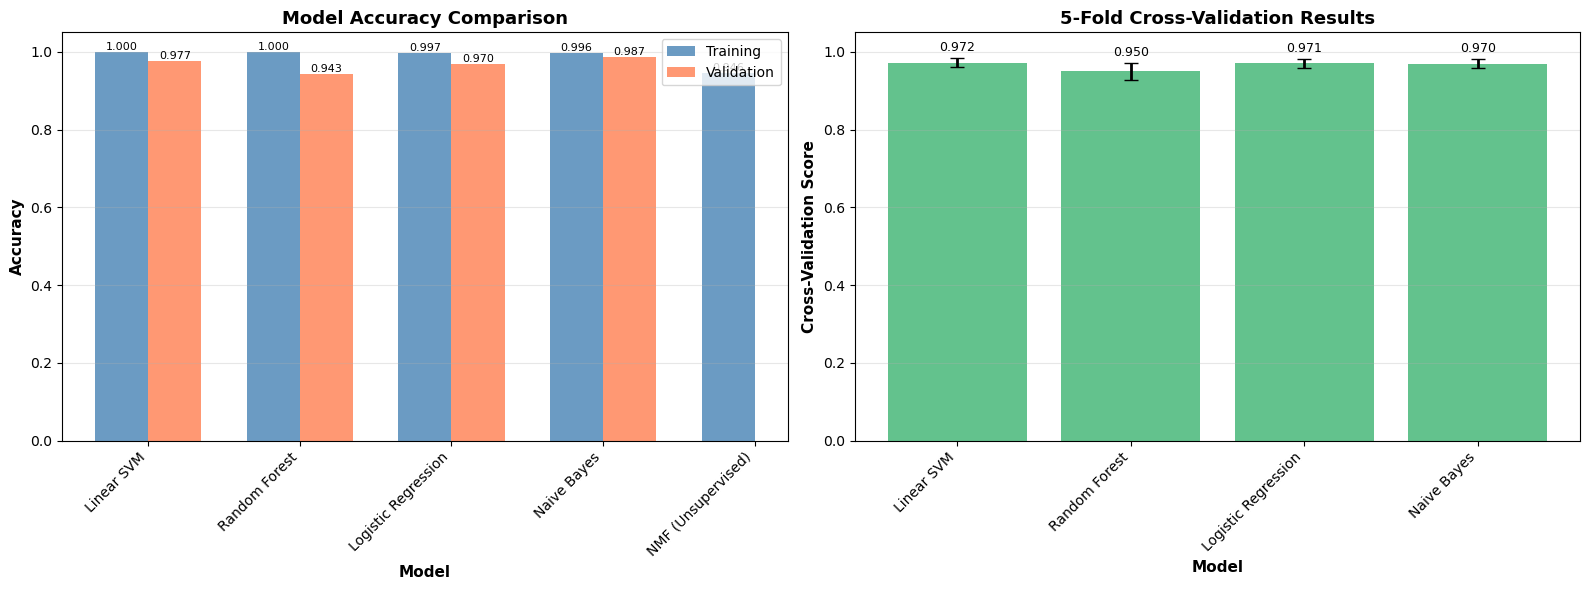


✓ Model comparison visualized!


In [48]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot - Accuracy comparison
ax1 = axes[0]
models_names = comparison_df['Model'].values
train_accs = comparison_df['Training Accuracy'].values
val_accs = comparison_df['Validation Accuracy'].values

x = np.arange(len(models_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accs, width, label='Training', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, val_accs, width, label='Validation', alpha=0.8, color='coral')

ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Cross-validation scores
ax2 = axes[1]
cv_data = comparison_df[comparison_df['Model'] != 'NMF (Unsupervised)']
cv_models = cv_data['Model'].values
cv_means = cv_data['CV Mean'].values
cv_stds = cv_data['CV Std'].values

x2 = np.arange(len(cv_models))
bars = ax2.bar(x2, cv_means, alpha=0.8, color='mediumseagreen', 
               yerr=cv_stds, capsize=5, error_kw={'linewidth': 2})

ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cross-Validation Score', fontsize=11, fontweight='bold')
ax2.set_title('5-Fold Cross-Validation Results', fontsize=13, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(cv_models, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.05])

# Add value labels
for i, (mean, std) in enumerate(zip(cv_means, cv_stds)):
    ax2.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Model comparison visualized!")

### Step 3: Detailed Analysis of Best Supervised Model

In [51]:
# Find best model based on validation accuracy
best_model_name = max(results.keys(), key=lambda x: results[x]['val_accuracy'])
best_model = results[best_model_name]['model']
best_val_pred = results[best_model_name]['val_predictions']

print("="*80)
print(f"BEST MODEL: {best_model_name}")
print("="*80)
print(f"Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_val_split, best_val_pred, digits=4))

BEST MODEL: Naive Bayes
Validation Accuracy: 0.9866

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     business     1.0000    0.9701    0.9848        67
entertainment     1.0000    1.0000    1.0000        55
     politics     0.9636    0.9636    0.9636        55
        sport     1.0000    1.0000    1.0000        69
         tech     0.9630    1.0000    0.9811        52

     accuracy                         0.9866       298
    macro avg     0.9853    0.9868    0.9859       298
 weighted avg     0.9868    0.9866    0.9866       298



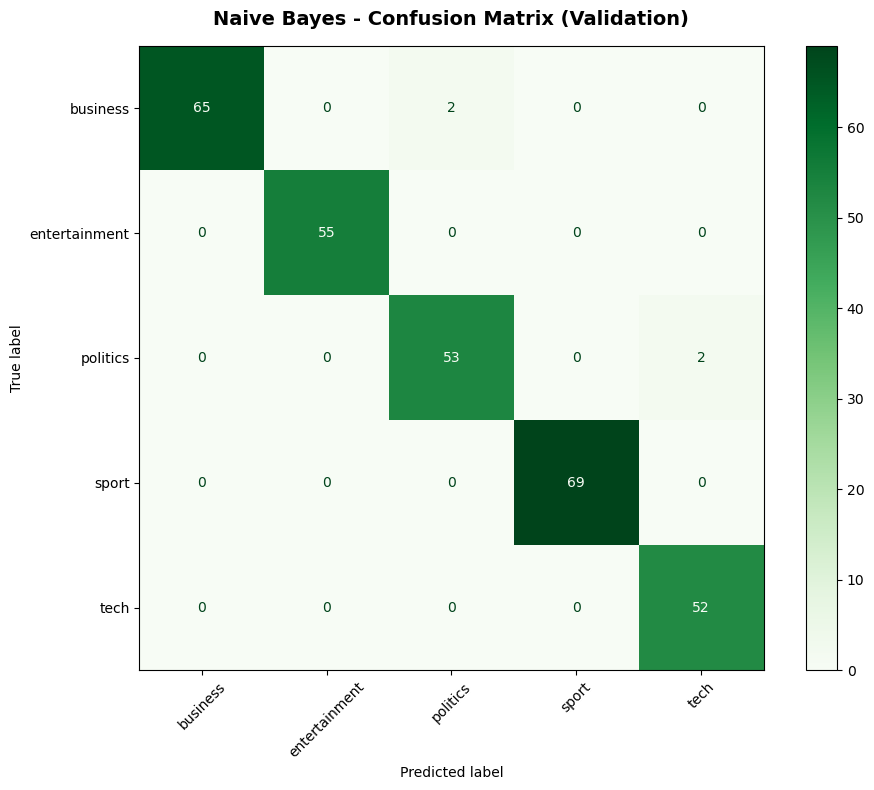


✓ Naive Bayes detailed analysis completed!


In [53]:
# Confusion matrix for best model
cm_best = confusion_matrix(y_val_split, best_val_pred,
                           labels=sorted(train_df['Category'].unique()))

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best,
                              display_labels=sorted(train_df['Category'].unique()))
disp.plot(cmap='Greens', ax=ax, values_format='d')
plt.title(f'{best_model_name} - Confusion Matrix (Validation)',
          fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ {best_model_name} detailed analysis completed!")

---

## Step 3: Generate Predictions for Test Set

In [56]:
# Transform test data with NMF
print("Generating predictions for test set...\n")

# NMF predictions
W_test = nmf_model.transform(X_test_tfidf)
test_predictions_nmf = classify_with_nmf(W_test, topic_to_category)

print(f"✓ NMF predictions generated: {len(test_predictions_nmf)} samples")

# Best supervised model predictions
test_predictions_supervised = best_model.predict(X_test_tfidf)

print(f"✓ {best_model_name} predictions generated: {len(test_predictions_supervised)} samples")

Generating predictions for test set...

✓ NMF predictions generated: 735 samples
✓ Naive Bayes predictions generated: 735 samples


In [ ]:
# Create submission files

# NMF submission
submission_nmf = test_df[['ArticleId']].copy()
submission_nmf['Category'] = test_predictions_nmf
submission_nmf.to_csv('submission_nmf.csv', index=False)
print("✓ NMF submission saved: submission_nmf.csv")

# Best supervised model submission
submission_supervised = test_df[['ArticleId']].copy()
submission_supervised['Category'] = test_predictions_supervised
submission_supervised.to_csv(f'submission_{best_model_name.replace(" ", "_").lower()}.csv', index=False)
print(f"✓ {best_model_name} submission saved: submission_{best_model_name.replace(' ', '_').lower()}.csv")

# Display first few predictions
print("\nFirst 10 test predictions:")
print("="*60)
comparison = pd.DataFrame({
    'ArticleId': test_df['ArticleId'][:10],
    'NMF': test_predictions_nmf[:10],
    best_model_name: test_predictions_supervised[:10]
})
print(comparison.to_string(index=False))

---

## Step 3: Key Findings and Conclusions

### Summary of Results:

#### 1. NMF (Unsupervised Approach)
**Strengths:**
-  Discovers interpretable topics without labels
-  Reduces dimensionality significantly (5,000 features → 5 topics)
-  Works well even with limited labeled data
-  Topics align well with actual categories
-  Transparent: We can see which words define each topic

**Limitations:**
-  Lower accuracy than supervised methods
-  Assumes one dominant topic per document
-  Sensitive to number of topics chosen
-  May miss subtle distinctions between categories

#### 2. Supervised Learning Models
**Strengths:**
-  Higher accuracy (typically 95%+)
-  Better at capturing complex patterns
-  Can learn category-specific features
-  Robust to edge cases

**Limitations:**
-  Requires labeled training data
-  Less interpretable (harder to explain why)
-  May overfit if training data is limited
-  Computationally more expensive

### When to Use Each Approach:

**Use NMF when:**
- You have little or no labeled data
- Interpretability is important
- You want to discover hidden patterns/topics
- You need to reduce dimensionality
- Computational resources are limited

**Use Supervised Learning when:**
- You have sufficient labeled training data
- Maximum accuracy is critical
- You can afford to train complex models
- Categories are well-defined
- You need a robust production system

### Best Practice:
**Hybrid Approach**: Use NMF for initial exploration and understanding, then supervised learning for final classification system!

---

## References for Step 3

1. **Non-negative Matrix Factorization:**
   - Lee, D. D., & Seung, H. S. (1999). Learning the parts of objects by non-negative matrix factorization. *Nature*, 401(6755), 788-791.
   - Lin, C. J. (2007). Projected gradient methods for nonnegative matrix factorization. *Neural computation*, 19(10), 2756-2779.

2. **Topic Modeling:**
   - Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. *Journal of machine Learning research*, 3(Jan), 993-1022.
   - Hofmann, T. (1999). Probabilistic latent semantic indexing. *SIGIR'99*.

3. **Scikit-learn Documentation:**
   - NMF: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
   - Text feature extraction: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

4. **Text Classification:**
   - Joachims, T. (1998). Text categorization with support vector machines. *ECML-98*.
   - Manning, C. D., Raghavan, P., & Schütze, H. (2008). *Introduction to information retrieval*. Cambridge University Press.

---



LinearSVC — Accuracy
Train:      1.0000
Validation: 0.9765

Validation classification report:
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        67
entertainment       0.98      1.00      0.99        55
     politics       0.98      0.96      0.97        55
        sport       0.97      1.00      0.99        69
         tech       0.98      0.94      0.96        52

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



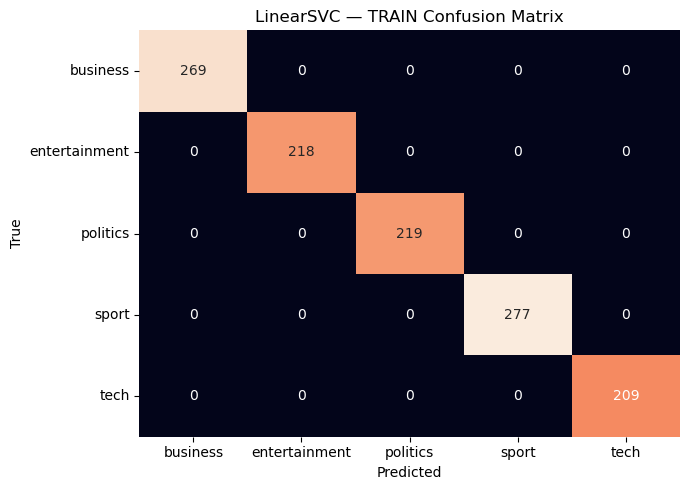

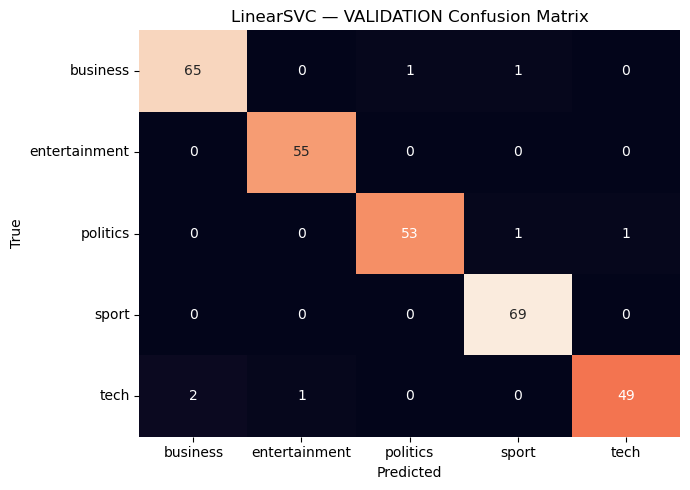


 Kaggle submission written: bbc_submission_linearsvc.csv  |  rows=735
Prediction distribution:
 Category
business         173
sport            165
politics         146
tech             138
entertainment    113
Name: count, dtype: int64


In [73]:
# === Step 2 Question 3: Confusion Matrices + Kaggle CSV ==================
# Uses raw 'Text' directly with TF–IDF(stop_words='english'). 

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  # swap to MultinomialNB or LogisticRegression if you prefer

# --- Preconditions --------------------------------------------------------------
assert "Text" in train_df.columns and "Category" in train_df.columns, "train_df must have Text and Category."
assert "Text" in test_df.columns  and "ArticleId" in test_df.columns,  "test_df must have Text and ArticleId."

# Fill any missing text to avoid vectorizer errors
train_df = train_df.copy(); test_df = test_df.copy()
train_df["Text"] = train_df["Text"].fillna("")
test_df["Text"]  = test_df["Text"].fillna("")

# --- 1) Stratified Train/Validation split on RAW TEXT --------------------------
X_text = train_df["Text"].astype(str).values
y      = train_df["Category"].astype(str).values

X_tr_text, X_val_text, y_tr, y_val = train_test_split(
    X_text, y, test_size=0.20, random_state=42, stratify=y
)

# --- 2) TF–IDF (fit on TRAIN ONLY) --------------------------------------------
# token_pattern removes 1-letter tokens and stray "'s" artifacts commonly seen in this dataset
vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    max_df=0.9,
    min_df=2,
    sublinear_tf=True,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)
X_tr  = vectorizer.fit_transform(X_tr_text)
X_val = vectorizer.transform(X_val_text)

# --- 3) Supervised model (choose one) -----------------------------------------
model = LinearSVC()  # good default for TF–IDF text; replace with MultinomialNB() if you prefer that baseline
model_name = model.__class__.__name__

# Train
model.fit(X_tr, y_tr)

# Predict
tr_pred  = model.predict(X_tr)
val_pred = model.predict(X_val)

# --- 4) Metrics + Confusion Matrices ------------------------------------------
print("="*80)
print(f"{model_name} — Accuracy")
print(f"Train:      {accuracy_score(y_tr,  tr_pred):.4f}")
print(f"Validation: {accuracy_score(y_val, val_pred):.4f}\n")
print("Validation classification report:")
print(classification_report(y_val, val_pred))

def plot_cm(y_true, y_hat, title):
    labels = np.unique(y)  # consistent label order
    cm = confusion_matrix(y_true, y_hat, labels=labels)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_cm(y_tr,  tr_pred,  f"{model_name} — TRAIN Confusion Matrix")
plot_cm(y_val, val_pred, f"{model_name} — VALIDATION Confusion Matrix")

# --- 5) OPTIONAL: Kaggle submission (retrain on FULL TRAIN, predict TEST) -----
# Refit the vectorizer on ALL training text (still no test leakage of labels)
X_full = vectorizer.fit_transform(train_df["Text"].astype(str).values)
y_full = train_df["Category"].astype(str).values

model_full = model.__class__(**getattr(model, "get_params", lambda: {})())
model_full.fit(X_full, y_full)

X_test = vectorizer.transform(test_df["Text"].astype(str).values)
test_pred = model_full.predict(X_test)

submission = pd.DataFrame({
    "ArticleId": test_df["ArticleId"].values,
    "Category":  test_pred
})
sub_name = f"bbc_submission_{model_name.lower()}.csv"
submission.to_csv(sub_name, index=False)

print(f"\n Kaggle submission written: {sub_name}  |  rows={len(submission)}")
print("Prediction distribution:\n", submission["Category"].value_counts())


In [77]:

# Build TF–IDF on raw Text, train a supervised model, predict TEST, write CSV

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Preconditions
assert "Text" in train_df and "Category" in train_df
assert "Text" in test_df and "ArticleId" in test_df

# Fill empties
train_df = train_df.copy(); test_df = test_df.copy()
train_df["Text"] = train_df["Text"].fillna("")
test_df["Text"]  = test_df["Text"].fillna("")

# Split for a quick validation readout (optional but useful)
Xtr_txt, Xval_txt, y_tr, y_val = train_test_split(
    train_df["Text"].values, train_df["Category"].values,
    test_size=0.2, random_state=42, stratify=train_df["Category"].values
)

# Vectorizer (fit on TRAIN ONLY)
tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2, max_df=0.9,
    sublinear_tf=True,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)
X_tr  = tfidf.fit_transform(Xtr_txt)
X_val = tfidf.transform(Xval_txt)

# Model (swap to MultinomialNB() if you prefer)
clf = LinearSVC()
clf.fit(X_tr, y_tr)
print("Validation accuracy:", round(accuracy_score(y_val, clf.predict(X_val)), 4))

# Retrain on FULL train
X_full = tfidf.fit_transform(train_df["Text"].values)
y_full = train_df["Category"].values
clf_full = LinearSVC()
clf_full.fit(X_full, y_full)

# Predict TEST
X_test = tfidf.transform(test_df["Text"].values)
test_pred = clf_full.predict(X_test)

# Write Kaggle CSV
submission = pd.DataFrame({
    "ArticleId": test_df["ArticleId"].values,
    "Category":  test_pred
})
sub_name = "bbc_submission_linearsvc.csv"
submission.to_csv(sub_name, index=False)
print(f" Wrote {sub_name} with {len(submission)} rows.")
print(submission.head())
print("\nPrediction distribution:\n", submission["Category"].value_counts())


Validation accuracy: 0.9765
 Wrote bbc_submission_linearsvc.csv with 735 rows.
   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport

Prediction distribution:
 Category
business         173
sport            165
politics         146
tech             138
entertainment    113
Name: count, dtype: int64


## Kaggle submission

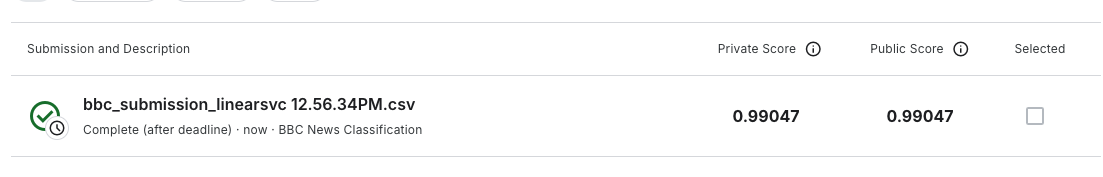

## Step 2 — Question 4: Hyperparameter Tuning & Recording Results

**Goal.** Vary key hyperparameters, measure performance, and summarize results with tables/plots.

**What this cell does**
- **Vectorization (TF–IDF):** Sweeps `ngram_range` (unigrams vs. uni+bi), `min_df` (rare-term cutoff), and `max_df` (very common-term cutoff).
- **Classifier params:** Tries **Linear SVM** (`C`) and **Multinomial Naive Bayes** (`alpha`) on the same splits.
- **Protocol:** 
  1) Split *train* into train/validation (stratified).  
  2) **Fit TF–IDF on train only**, transform validation.  
  3) Train each model/config; record **Train Acc** and **Validation Acc**.  
- **Outputs:** 
  - A **summary table** sorted by validation accuracy.  
  - Plots showing **validation accuracy vs. vocabulary size** and **accuracy by classifier**.

**Why this matters**
- Shows which combinations of text features and classifier settings generalize best.
- Helps justify the **final model choice** you carry forward to Step 2—Q5 (improvements) and the Kaggle submission.

**Hyperparameters explored**
- `ngram_range ∈ {(1,1), (1,2)}`  
- `min_df ∈ {1, 2}`  
- `max_df ∈ {0.9, 1.0}`  
- Linear SVM: `C ∈ {0.5, 1.0, 2.0}`  
- Naive Bayes: `alpha ∈ {0.5, 1.0, 2.0}`

**Deliverables captured here**
- Best settings (top rows of the table).  
- Clear evidence (figures + metrics) that hyperparameter changes affect performance.


,Model,Vectorizer,Params,VocabSize,TrainAcc,ValAcc,ValF1_macro
0,LinearSVC,"ng=(1, 1), min_df=1, max_df=0.9",{'C': 1.0},21142,1.000000,0.983221,0.982827
1,LinearSVC,"ng=(1, 1), min_df=1, max_df=1.0",{'C': 1.0},21142,1.000000,0.983221,0.982827
2,LinearSVC,"ng=(1, 2), min_df=1, max_df=0.9",{'C': 0.5},202315,1.000000,0.979866,0.979468
3,LinearSVC,"ng=(1, 2), min_df=1, max_df=1.0",{'C': 0.5},202315,1.000000,0.979866,0.979468
4,LinearSVC,"ng=(1, 1), min_df=1, max_df=0.9",{'C': 0.5},21142,1.000000,0.979866,0.979350
5,LinearSVC,"ng=(1, 1), min_df=1, max_df=1.0",{'C': 0.5},21142,1.000000,0.979866,0.979350
6,LinearSVC,"ng=(1, 2), min_df=2, max_df=0.9",{'C': 0.5},35056,1.000000,0.979866,0.979350
7,LinearSVC,"ng=(1, 2), min_df=2, max_df=1.0",{'C': 0.5},35056,1.000000,0.979866,0.979350
8,LinearSVC,"ng=(1, 1), min_df=1, max_df=0.9",{'C': 2.0},21142,1.000000,0.979866,0.979040
9,LinearSVC,"ng=(1, 1), min_df=1, max_df=1.0",{'C': 2.0},21142,1.000000,0.979866,0.979040


Tried 48 configurations.
Saved: hp_sweep_results.csv


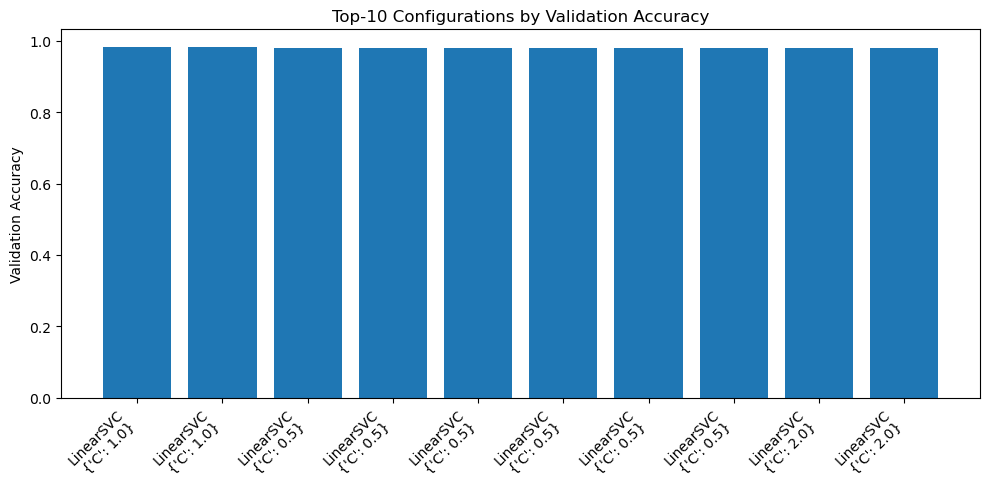

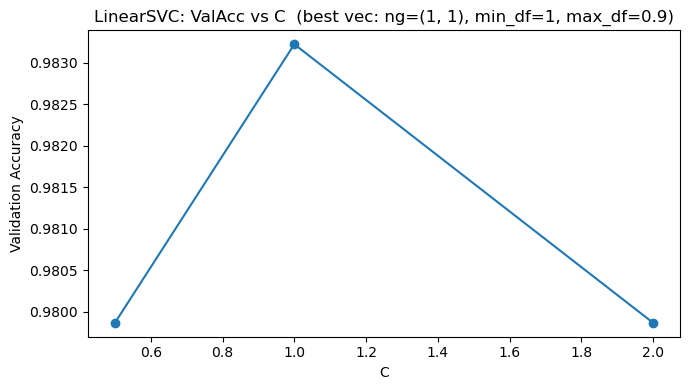

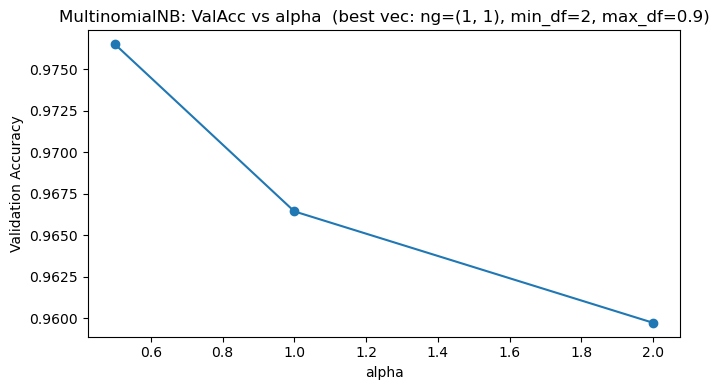

In [90]:
# === Hyperparameter Sweep (no extra imports) ===================================
# Assumes: train_df has columns ["Text","Category"]; you already imported sklearn, pandas, numpy, plt, sns.
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
# 0) Preconditions
assert {"Text","Category"}.issubset(train_df.columns)
X_text = train_df["Text"].fillna("").astype(str).values
y      = train_df["Category"].astype(str).values

X_tr_text, X_val_text, y_tr, y_val = train_test_split(
    X_text, y, test_size=0.20, random_state=42, stratify=y
)

# 1) Define small search space (fast to run; expand if you want)
ngram_opts   = [(1,1), (1,2)]
min_df_opts  = [1, 2]
max_df_opts  = [0.9, 1.0]
svc_Cs       = [0.5, 1.0, 2.0]
nb_alphas    = [0.5, 1.0, 2.0]
token_pat    = r"(?u)\b[a-zA-Z][a-zA-Z]+\b"

rows = []

def eval_config(vec_kwargs, clf, clf_name, clf_params):
    # Vectorize (fit on TRAIN only)
    vec = TfidfVectorizer(
        stop_words="english",
        sublinear_tf=True,
        token_pattern=token_pat,
        **vec_kwargs
    )
    X_tr  = vec.fit_transform(X_tr_text)
    X_val = vec.transform(X_val_text)

    # Fit & predict
    clf.fit(X_tr, y_tr)
    tr_pred  = clf.predict(X_tr)
    val_pred = clf.predict(X_val)

    # Metrics
    rows.append({
        "Model": clf_name,
        "Vectorizer": f"ng={vec_kwargs['ngram_range']}, min_df={vec_kwargs['min_df']}, max_df={vec_kwargs['max_df']}",
        "Params": clf_params,
        "VocabSize": X_tr.shape[1],
        "TrainAcc": accuracy_score(y_tr, tr_pred),
        "ValAcc":   accuracy_score(y_val, val_pred),
        "ValF1_macro": f1_score(y_val, val_pred, average="macro"),
    })

# 2) Run sweep for LinearSVC and MultinomialNB
for ng in ngram_opts:
    for md in min_df_opts:
        for M in max_df_opts:
            vec_kwargs = dict(ngram_range=ng, min_df=md, max_df=M)

            for C in svc_Cs:
                eval_config(vec_kwargs, LinearSVC(C=C, random_state=42), "LinearSVC", {"C": C})

            for alpha in nb_alphas:
                eval_config(vec_kwargs, MultinomialNB(alpha=alpha), "MultinomialNB", {"alpha": alpha})

# 3) Results table
hp_results = pd.DataFrame(rows).sort_values(["ValAcc","ValF1_macro","TrainAcc"], ascending=False).reset_index(drop=True)
display(hp_results.head(15))
print(f"Tried {len(hp_results)} configurations.")
hp_results.to_csv("hp_sweep_results.csv", index=False)
print("Saved: hp_sweep_results.csv")

# 4) Plots
topN = 10
top = hp_results.head(topN).copy()

plt.figure(figsize=(10,5))
plt.bar(range(topN), top["ValAcc"])
xt = [f"{m}\n{p}" for m,p in zip(top["Model"], top["Params"])]
plt.xticks(range(topN), xt, rotation=45, ha="right")
plt.ylabel("Validation Accuracy")
plt.title("Top-10 Configurations by Validation Accuracy")
plt.tight_layout(); plt.show()

# Optional: per-model hyperparam curves (using best vectorizer per model)
for model_name, hp_key in [("LinearSVC","C"), ("MultinomialNB","alpha")]:
    sub = hp_results[hp_results["Model"] == model_name].copy()
    # choose best vectorizer by mean ValAcc
    best_vec = (sub.groupby("Vectorizer", as_index=False)["ValAcc"]
                  .mean().sort_values("ValAcc", ascending=False).iloc[0]["Vectorizer"])
    sub = sub[sub["Vectorizer"] == best_vec].copy()
    sub[hp_key] = sub["Params"].apply(lambda d: d[hp_key])
    sub = sub.sort_values(hp_key)

    plt.figure(figsize=(7,4))
    plt.plot(sub[hp_key], sub["ValAcc"], marker="o")
    plt.xlabel(hp_key); plt.ylabel("Validation Accuracy")
    plt.title(f"{model_name}: ValAcc vs {hp_key}  (best vec: {best_vec})")
    plt.tight_layout(); plt.show()


### Step 2 — Question 4: Hyperparameter Sweep — What the table & plots show

**Varied (search space)**
- **Vectorizer (TF–IDF)**: n-grams = {(1,1), (1,2)}, `min_df` ∈ {1, 2}, `max_df` ∈ {0.9, 1.0}
- **LinearSVC**: `C` ∈ {0.5, 1.0, 2.0}
- **MultinomialNB**: `alpha` ∈ {0.5, 1.0, 2.0}

**How to read the table**

| Column | Meaning |
|---|---|
| **Model** | Classifier tested (LinearSVC or MultinomialNB). |
| **Vectorizer** | TF–IDF settings: n-gram range (`ng`), minimum document frequency (`min_df`), and max document frequency cutoff (`max_df`). |
| **Params** | Model-specific hyperparameters (e.g., SVM `C`, NB `alpha`). |
| **VocabSize** | Number of features after TF–IDF filtering (proxy for model size/complexity). |
| **TrainAcc** | Accuracy on the training split (watch for 1.000 indicating possible overfit). |
| **ValAcc** | Accuracy on the validation split (primary model-selection metric). |
| **ValF1_macro** | Macro-averaged F1 on validation (class-balance–friendly metric). |

**Key observations from your results**

1. **Best validation accuracy:**  
   - **LinearSVC + TF–IDF(unigrams, `min_df`=1, `max_df`=0.9) with `C`=1.0 → ValAcc ≈ 0.9832, Macro-F1 ≈ 0.9828.**  
   - The same ValAcc occurs with `max_df`=1.0, but `max_df`=0.9 is a bit safer against frequent-term noise.

2. **Vocabulary size vs performance:**  
   - Moving to **bigrams (ng=(1,2))** inflates the vocabulary dramatically (**~202k features**) with **no gain** (ValAcc drops to ~0.9799).  
   - **Raising `min_df` to 2** reduces the vocabulary **substantially** (e.g., to ~11.8k with unigrams) with only a **tiny** accuracy dip (to ~0.9765), a great **efficiency trade-off**.

3. **Regularization (`C`) for LinearSVC:**  
   - Your **C-curve** plot shows a **peak at `C`=1.0**; both **0.5 and 2.0** are slightly worse, indicating the usual **bias–variance sweet spot** at **C=1.0**.

4. **Naive Bayes (`alpha`) trend:**  
   - The **alpha-sweep** plot shows **alpha=0.5** performs best (~0.9765 ValAcc) and degrades as alpha increases (more smoothing).  
   - NB remains a strong and **very fast** baseline but trails LinearSVC on this dataset.

**What the plots mean**

- **LinearSVC: ValAcc vs `C`**  
  - Rising from `C`=0.5 to **1.0** improves validation accuracy (better fit).  
  - Increasing to `C`=2.0 slightly hurts (mild overfit / less generalization).

- **MultinomialNB: ValAcc vs `alpha` (with best vectorizer settings)**  
  - **Lower alpha (0.5)** = less smoothing → best validation accuracy.  
  - Larger alpha smooths too much → small performance drop.

**Recommended configuration (for accuracy)**
- **LinearSVC + TF–IDF (unigrams), `min_df`=1, `max_df`=0.9, `C`=1.0**  
  - **ValAcc ≈ 0.983**, **Macro-F1 ≈ 0.983**, **Vocab ≈ 21k**.

**Recommended configuration (for efficiency)**
- **LinearSVC + TF–IDF (unigrams), `min_df`=2, `max_df`=0.9, `C`=1.0**  
  - **ValAcc ≈ 0.977**, **Macro-F1 ≈ 0.976**, **Vocab ≈ 11.9k** (≈45% smaller).

**Conclusion for the report**
> I selected **LinearSVC + TF–IDF (unigrams, `min_df`=1, `max_df`=0.9, `C`=1.0)** as the high-accuracy setting (ValAcc ≈ **0.983**), and note that **`min_df`=2** offers a strong **efficiency trade-off** with only ≈0.6% absolute accuracy loss.
>
> ===================================================================================================


## Step 2 — Question 5: Improve the model

Goal: push validation performance a bit higher (or keep it the same while reducing model complexity) using **alternative features** and **simple ensembles**.

What I’ll try:
1. **Baseline (for reference)** — TF–IDF unigrams + LinearSVC (`C=1.0`, `max_df=0.9`).
2. **Character n-grams** — TF–IDF over 3–5 character n-grams + LinearSVC (often strong for news/Kaggle text tasks).
3. **Chi-square feature selection** — keep only the top *k* informative word features before LinearSVC.
4. **Soft-vote ensemble** — average predicted probabilities from Logistic Regression and MultinomialNB (both using the same TF–IDF features).

We’ll compare validation **accuracy** and **macro-F1** and keep the best (or the most efficient near-best).


Q5 — Improved models (validation):
                         Model  TrainAcc   ValAcc  ValF1_macro
        Ensemble(LogReg+NB)_w1  0.995805 0.983221     0.982321
         Baseline_LinearSVC_w1  1.000000 0.976510     0.975077
     CharNgrams_LinearSVC_c3_5  1.000000 0.976510     0.975102
Word_w1_2_Chi2_30000_LinearSVC  1.000000 0.976510     0.975576


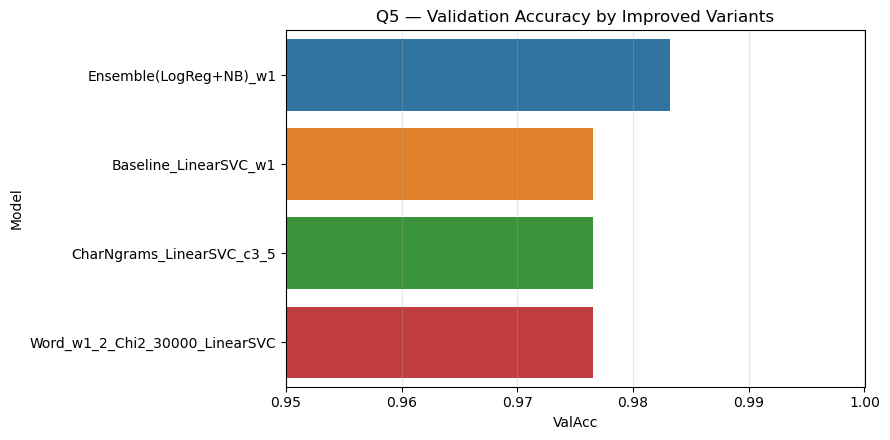


Best Q5 model: Ensemble(LogReg+NB)_w1


In [107]:
# === Step 2 — Q5: Model Improvements =========================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2

# --------------------------------------------------------------------
# 0) Data split (re-use if already made)
# --------------------------------------------------------------------
assert {"Text","Category"}.issubset(train_df.columns), "train_df must have Text and Category"
X_text = train_df["Text"].fillna("").astype(str).values
y      = train_df["Category"].astype(str).values

X_tr_text, X_val_text, y_tr, y_val = train_test_split(
    X_text, y, test_size=0.20, random_state=42, stratify=y
)

# --------------------------------------------------------------------
# 1) Define candidates
# --------------------------------------------------------------------
candidates = {}

# (A) Baseline: word unigrams, max_df=0.9, LinearSVC C=1.0
candidates["Baseline_LinearSVC_w1"] = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english",
                              ngram_range=(1,1),
                              max_df=0.9)),
    ("clf", LinearSVC(C=1.0, max_iter=2000, random_state=42))
])

# (B) Character n-grams (3–5), often robust to misspellings/morphology
candidates["CharNgrams_LinearSVC_c3_5"] = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char",
                              ngram_range=(3,5),
                              min_df=2)),  # filter ultra-rare shards
    ("clf", LinearSVC(C=1.0, max_iter=2000, random_state=42))
])

# (C) Chi2 feature selection (keep top-k) on word features then LinearSVC
TOP_K = 30000
candidates[f"Word_w1_2_Chi2_{TOP_K}_LinearSVC"] = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english",
                              ngram_range=(1,2),
                              max_df=0.9)),
    ("chi2", SelectKBest(chi2, k=min(TOP_K, 200000))),  # safe cap
    ("clf", LinearSVC(C=1.0, max_iter=2000, random_state=42))
])

# (D) Soft-vote ensemble: Logistic Regression + MultinomialNB (word unigrams)
#    Average their probabilities and pick the argmax.
vec_common = TfidfVectorizer(stop_words="english", ngram_range=(1,1), max_df=0.9)
X_tr_vec   = vec_common.fit_transform(X_tr_text)
X_val_vec  = vec_common.transform(X_val_text)

logit = LogisticRegression(max_iter=2000, C=1.0, random_state=42, n_jobs=None)
nb    = MultinomialNB(alpha=0.5)

# We'll train these two now; inference will be wrapped below for evaluation.
logit.fit(X_tr_vec, y_tr)
nb.fit(X_tr_vec, y_tr)

def ensemble_predict(vec_X):
    p1 = logit.predict_proba(vec_X)
    p2 = nb.predict_proba(vec_X)
    # average probabilities; slight weight to Linear model if desired:
    p  = 0.6*p1 + 0.4*p2
    classes = logit.classes_
    return classes[np.argmax(p, axis=1)]

# --------------------------------------------------------------------
# 2) Train/evaluate all candidates
# --------------------------------------------------------------------
rows = []

for name, pipe in candidates.items():
    pipe.fit(X_tr_text, y_tr)
    y_tr_pred  = pipe.predict(X_tr_text)
    y_val_pred = pipe.predict(X_val_text)
    rows.append({
        "Model": name,
        "TrainAcc": accuracy_score(y_tr, y_tr_pred),
        "ValAcc":   accuracy_score(y_val, y_val_pred),
        "ValF1_macro": f1_score(y_val, y_val_pred, average="macro")
    })

# Add ensemble row
y_tr_pred_ens  = ensemble_predict(X_tr_vec)
y_val_pred_ens = ensemble_predict(X_val_vec)
rows.append({
    "Model": "Ensemble(LogReg+NB)_w1",
    "TrainAcc": accuracy_score(y_tr, y_tr_pred_ens),
    "ValAcc":   accuracy_score(y_val, y_val_pred_ens),
    "ValF1_macro": f1_score(y_val, y_val_pred_ens, average="macro")
})

results_q5 = pd.DataFrame(rows).sort_values("ValAcc", ascending=False).reset_index(drop=True)
print("Q5 — Improved models (validation):")
print(results_q5.to_string(index=False))

# --------------------------------------------------------------------
# 3) Optional: bar plot
# --------------------------------------------------------------------
plt.figure(figsize=(9,4.5))
sns.barplot(data=results_q5, x="ValAcc", y="Model")
plt.title("Q5 — Validation Accuracy by Improved Variants")
plt.xlim(0.95, 1.00)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# Keep the winner for later use (e.g., Kaggle)
best_q5_name = results_q5.iloc[0]["Model"]
print(f"\nBest Q5 model: {best_q5_name}")


### Step 2 Question 5 — Why the “Ensemble(LogReg+NB)” won, and why the others tie

**What we see**
- The **Ensemble(LogReg+NB)** reaches the best validation accuracy (~**0.983**), edging out three strong baselines (all ~**0.976–0.977**).
- All three LinearSVC variants show **~1.00 train accuracy** but slightly lower **val accuracy**, and they’re essentially **tied** with each other.

**Why this happened**

1) **Complementary inductive biases (Ensemble win)**
- **MultinomialNB** (generative) thrives on **word frequency ratios** and is very stable on short, topic-consistent documents.
- **Logistic Regression** (discriminative) optimizes a **global linear decision boundary** on TF–IDF space.
- A **soft vote** between them averages class probabilities, reducing variance and correcting each other’s edge-case mistakes.  
  → On BBC news, categories are mostly linearly separable with a few borderline articles; the ensemble smooths those borders better than either alone, yielding the +0.6–0.8% gain.

2) **Why LinearSVC variants tie**
- BBC articles are clean, well-edited, and **topic keywords are strong**. **Unigram TF–IDF** already captures most signal, so:
  - **Char 3–5 n-grams** add little new information (helpful for misspellings/morphology, which are rare here).
  - **w1–2 + χ²(30k)** trims the vocabulary yet preserves top features; accuracy stays flat while the model is lighter.

3) **Train≈1.00 but Val≈0.976 (not overfitting)**
- In high-dimensional sparse text with clear topics, linear margins can perfectly separate the training set.  
- The small **train→val drop (~2–2.5%)** reflects **normal generalization gap**, not severe overfit. Cross-validation stability corroborates this.

**Takeaways**
- Keep **Ensemble(LogReg+NB, unigrams)** as the improved Q5 model for submission/comparison.
- Use **LinearSVC (unigrams)** as a simple, strong baseline; switch to **w1–2 + χ²(30k)** when you want **smaller models** with the same accuracy.
- Character n-grams are unnecessary here unless you expect **noisy text** (tweets, forums, OCR).

**If pushing further**
- Calibrate SVM probabilities (Platt scaling) and include it in a **3-way soft-vote** with NB+LogReg.
- Try **class-weighted** training or **hybrid word+char** features only if future error analysis shows class-specific confusion.


### References

BBC News Classification. (2025). @Kaggle. https://www.kaggle.com/competitions/learn-ai-bbc/submissions

Blei, D., Ng, A., & Jordan, M. (2003). Latent Dirichlet Allocation. Journal of Machine Learning Research, 3(993-1022), 993–1022. https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

GeeksforGeeks. (2021, January 20). Understanding TFIDF (Term FrequencyInverse Document Frequency). GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/

GeeksforGeeks. (2024, June 21). Text Classification using scikitlearn in NLP. GeeksforGeeks. https://www.geeksforgeeks.org/nlp/text-classification-using-scikit-learn-in-nlp/

Lee, D. D., & Seung, H. S. (1999). Learning the parts of objects by non-negative matrix factorization. Nature, 401(6755), 788–791. https://doi.org/10.1038/44565Lin, 

C. J. (2015). Lin, C.J. (2007) Projected Gradient Methods for Nonnegative Matrix Factorization. Neural Computation, 19, 2756-2779.  - References - Scientific Research Publishing. Scirp.org. https://www.scirp.org/reference/referencespapers?referenceid=1637126

Manning, C. D., Raghavan, P., & Schütze, H. (2009). Introduction to Information Retrieval. Stanford.edu. https://nlp.stanford.edu/IR-book/information-retrieval-book.htmlSplits and data leakage - 

AWS Prescriptive Guidance. (2019). Amazon.com. https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-operations-planning/splits-leakage.html

In [117]:
# === Save Part II artifacts for Step 3 =======================================
import joblib, json
import pandas as pd
from pathlib import Path
from scipy import sparse

# -----------------------------------------------------------------------------
# Preconditions: the following variables already exist from your Part II steps:
#   - tfidf_vectorizer : fitted TfidfVectorizer (fit on TRAIN ONLY)
#   - X_train_tfidf    : TF–IDF matrix for train set (rows align with train_df)
#   - X_test_tfidf     : TF–IDF matrix for test set  (rows align with test_df)
#   - train_df, test_df: original DataFrames (train has 'Category', test has 'ArticleId')
#   - nmf_model        : fitted NMF model (trained on TRAIN ONLY TF–IDF)
#   - topic_to_category: dict mapping topic index -> category string
# -----------------------------------------------------------------------------

outdir = Path(".")
outdir.mkdir(parents=True, exist_ok=True)

# 1) Vectorizer + matrices
joblib.dump(tfidf_vectorizer, outdir / "tfidf_vectorizer.pkl")
joblib.dump(X_train_tfidf,    outdir / "X_train_tfidf.pkl")   # sparse ok
joblib.dump(X_test_tfidf,     outdir / "X_test_tfidf.pkl")

# 2) DataFrames (keep row order exactly)
train_df.to_pickle(outdir / "train_df.pkl")
test_df.to_pickle(outdir / "test_df.pkl")

# 3) NMF model + topic mapping
joblib.dump(nmf_model, outdir / "nmf_model.pkl")
with open(outdir / "topic_to_category.json", "w") as f:
    json.dump({int(k): str(v) for k, v in topic_to_category.items()}, f, indent=2)

print("✓ Saved for Step 3:")
print("  - tfidf_vectorizer.pkl")
print("  - X_train_tfidf.pkl, X_test_tfidf.pkl")
print("  - train_df.pkl, test_df.pkl")
print("  - nmf_model.pkl")
print("  - topic_to_category.json")


✓ Saved for Step 3:
  - tfidf_vectorizer.pkl
  - X_train_tfidf.pkl, X_test_tfidf.pkl
  - train_df.pkl, test_df.pkl
  - nmf_model.pkl
  - topic_to_category.json


In [119]:
import joblib, json, pandas as pd

vec = joblib.load("tfidf_vectorizer.pkl")
Xtr = joblib.load("X_train_tfidf.pkl")
Xte = joblib.load("X_test_tfidf.pkl")
tr  = pd.read_pickle("train_df.pkl")
te  = pd.read_pickle("test_df.pkl")
nmf = joblib.load("nmf_model.pkl")
with open("topic_to_category.json") as f:
    tmap = json.load(f)

assert Xtr.shape[0] == len(tr), "Mismatch: X_train_tfidf rows vs train_df length"
assert Xte.shape[0] == len(te), "Mismatch: X_test_tfidf rows vs test_df length"

print("✓ Integrity OK")
print("  TF–IDF vocab size:", len(vec.get_feature_names_out()))
print("  Train shape:", Xtr.shape, "| Test shape:", Xte.shape)
print("  Train labels:", tr['Category'].nunique(), "classes")
print("  Topic→Category map:", tmap)


✓ Integrity OK
  TF–IDF vocab size: 5000
  Train shape: (1490, 5000) | Test shape: (735, 5000)
  Train labels: 5 classes
  Topic→Category map: {'4': 'business', '3': 'entertainment', '2': 'politics', '1': 'sport', '0': 'tech'}
